In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# REading in toy college basketball team statistics, sourced from Kaggle:

Link: https://www.kaggle.com/andrewsundberg/college-basketball-dataset

#Using 2013-2019 ncaa means tournament as training, 2021 tournament (self-labeled) as test set

This serves as an attempt to analyze the classiification for successful, i.e., advance to sweet 16, and unsuccessful tournament teams

In [2]:
train_df = pd.read_csv('./archive/cbb.csv')
test_df = pd.read_csv('./archive/cbb21.csv')
train_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


# 1#. Preprocessing data. We are looking only at NCAA tournament results, so filter the dataset for only those teams who advanced to the ncaa tournament

In [3]:
train_df = train_df[train_df['SEED'] < 17]

# Creating target classes:

## 0 - did not advance to sweet 16 or above
## 1 - advanced to sweet 16 or further

# This will lead to a nearly 1:3 P:N class imbalance. This is of particular issue, as the hardest part of this classification task is recognizing TPs

We will experiment with over-sampling to mitigate the imbalance

In [4]:
y_post = np.array(train_df['POSTSEASON'])
y_post = y_post.reshape(len(y_post),1)
cats = np.array(['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68'][::-1])
cats = list(cats.reshape(1,-1))

# turn categorical y to one-hot vector, then group
onehot = OneHotEncoder(categories=cats, sparse=False)
onehot_encode = onehot.fit_transform(y_post)
# creating true classes, 0 - Rd64/32 and 1 - Rd16/8/4
y_group=np.array([None]*onehot_encode.shape[0])
for i,row in enumerate(onehot_encode):
## for grouping, 1 if sweet 16 or further 0 for 32 or worse #:1 classi mbalance
    idx = list(np.where(row == 1)[0])
   
    if idx[0] < 2.5:
        y_group[i] = 0
    elif idx[0] > 2.5:
        y_group[i] = 1
        
y_class = y_group.astype(int)

# Creating pre-processed X array to be scaled and balanced for even P:N ratio

In [5]:
x_full = ['TEAM', 'ADJOE', 'ADJDE','BARTHAG','EFG_O','EFG_D','TOR', 'TORD', 'ORB', 'DRB','FTR','FTRD','2P_O', '2P_D', '3P_O', '3P_D','ADJ_T','WAB']
X_full = train_df[x_full]

# after extracting highly-correlated man-made metrics
x_cats = ['TEAM','ADJOE','ADJDE','EFG_O','EFG_D','TOR', 'TORD', 'ORB','FTRD', '2P_D', '3P_O', '3P_D','ADJ_T']
#x_train, x_test, y_train, y_test = train_test_split(train_df[x_cats],y_group,test_size=0.1)

X = train_df[x_cats]
X=X.set_index('TEAM')

# SHOWING CORRELATION MATRICES FOR TRIMMING REPETITVE VARIABLES. THIS IS TO AVOID EXTRA OVERFITTING BY REPEATING THE SAME FEATURE EMPHASIS FOR CLASSIFICATION

# IN THE END, I TOOK OUT MAN-MADE STATISTICS, BARTHAG AND WAB, AND FTR AND DRB DUE TO THE SIMILAR DISTRIBUTIONS (COMPARING BOXPLOTS) BETWEEN CLASSES AND LACK OF STRONG CORRELATIONS

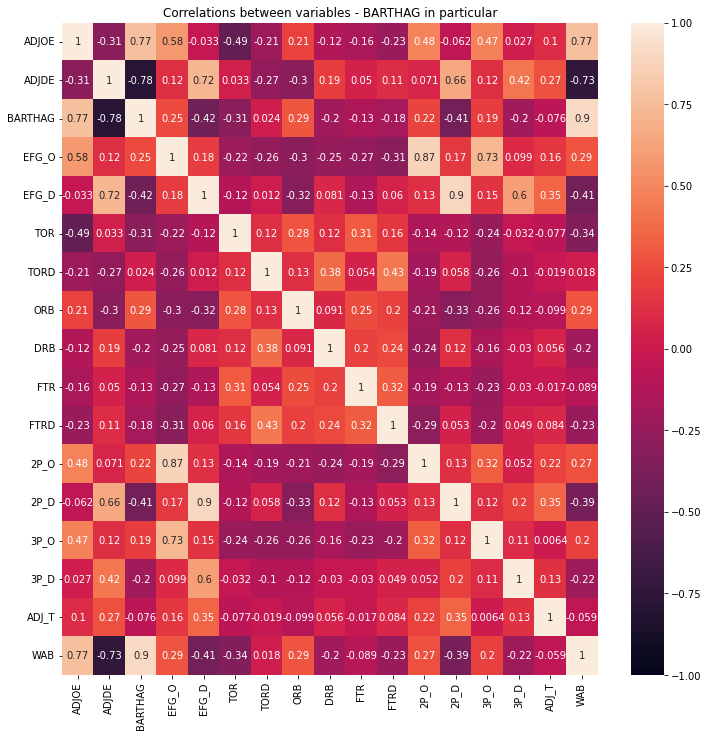

In [6]:
plt.figure(figsize=(12,12))
sns.heatmap(X_full.corr(),vmin=-1,vmax=1,annot=True)
plt.title('Correlations between variables - BARTHAG in particular')
plt.show()

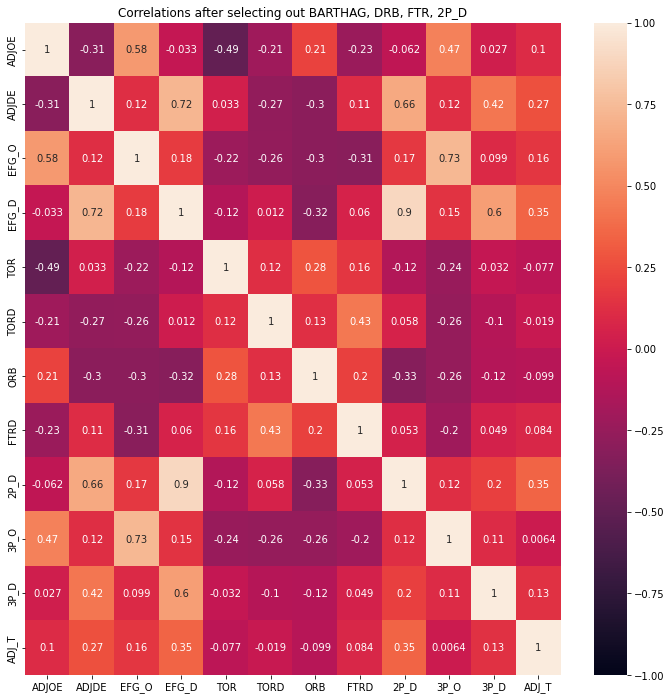

In [7]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),vmin=-1,vmax=1,annot=True)
plt.title('Correlations after selecting out BARTHAG, DRB, FTR, 2P_D')
plt.show()

# STEP 2 - scale and feature extraction via PCA components

## we will explore PCA features, first on the imbalanced data for visualization

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
pca = PCA(n_components=10)
Xt = scaler.fit_transform(X)
Xpca = pca.fit_transform(Xt)

In [9]:
Xpca.shape

(476, 10)

In [10]:
def plot_pca(pca,xp,yp,dim):
    ''' scatter plot (in 2D or 3D) of the transform X data with pca space
    I: pca (pca OBJ) xp (pca array), yp (for labeling the classes), 
    dim (int) 2 for 2d, 3 for 3d
    
    OUTPUTS A PLOT as well as Explained Variance Stats'''
    plt.rcParams.update({'font.size': 22})
    expl_var = pca.explained_variance_ratio_
    print('Explained variance % of PCA components : ')
    print(np.round(expl_var,3))
    print('Percentage of variance explained  first 3 pca components: ' + str((np.round(expl_var[0:3].sum(),3))))
    
    #plotting
    fig = plt.figure(figsize=(12,10))
    if dim == 2:
        plt.scatter(xp[:,0],xp[:,1],c=yp, cmap='winter')
        plt.xlabel('Primary PCA component')
        plt.ylabel('Secodnary PCA Component',)
        
    elif dim == 3:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(xp[:,0],xp[:,1],xp[:,2],c=yp,cmap='winter')


        ax.set_xlabel('pca1')
        ax.set_ylabel('pca2')
        ax.set_zlabel('pca3')
        ax.view_init(40,-25)
    plt.show()

Explained variance % of PCA components : 
[0.282 0.217 0.108 0.089 0.077 0.073 0.056 0.053 0.022 0.018]
Percentage of variance explained  first 3 pca components: 0.607


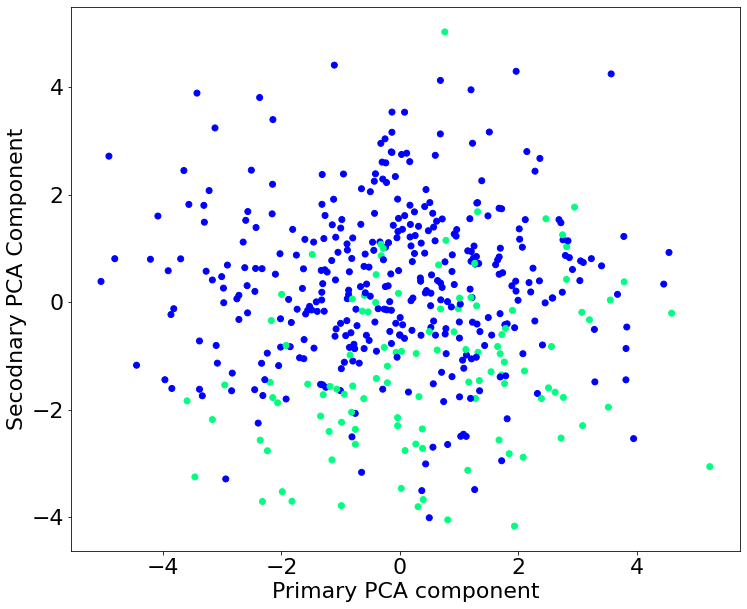

Explained variance % of PCA components : 
[0.282 0.217 0.108 0.089 0.077 0.073 0.056 0.053 0.022 0.018]
Percentage of variance explained  first 3 pca components: 0.607


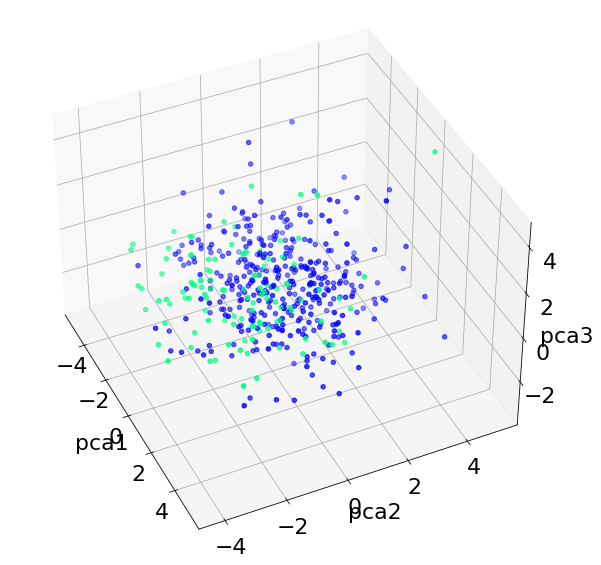

In [11]:
plot_pca(pca,Xpca,y_class,2)
plot_pca(pca,Xpca,y_class,3)

In [12]:
## MAKING TEST DATA SET
test_21 = test_df[test_df['SEED'] < 17.0]
# LIST OF SWEET 16 TEAMS IN THE 2021 NCAA TOURNAMENT
# had a lot of upset, large variability - GOAL is to predict > 50% Sweet 16 teams
sweet_16 = ['Gonzaga', 'Creighton', 'USC', 'Oregon', 'Michigan', 'Florida St.','UCLA','Alabama','Baylor','Villanova','Arkansas','Oral Roberts', 'Loyola Chicago', 'Oregon St.', 'Syracuse','Houston']
index_list = []
for t in sweet_16:
    index_list.append(test_21.loc[test_21['TEAM'] == t].index[0])
sweet_g21 = np.zeros(test_21.shape[0])
sweet_g21[index_list] = 1
X21 = test_21[x_cats]
X21=X21.set_index('TEAM')
X21t = scaler.fit_transform(X21)
X21pca = pca.transform(X21t)

# SVM on inbalanced data

In [13]:
svm = sklearn.svm.LinearSVC()
svm.fit(Xpca[:,0:3],y_class)
print(svm.score(Xpca[:,0:3],y_class))
print('This training accuracy is misleading due to class imbalance, among others')

0.8298319327731093
This training accuracy is misleading due to class imbalance, among others


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
first_svm = svm.predict(X21pca[:,0:3])
cf = classification_report(sweet_g21,first_svm)
print('SVM with imbalanced data on test set - notice low recall - THE GOAL OF OUR ALGORITHM IS TO MAXIMIZE RECALL')
print(cf)

SVM with imbalanced data on test set - notice low recall - THE GOAL OF OUR ALGORITHM IS TO MAXIMIZE RECALL
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        52
         1.0       0.75      0.38      0.50        16

    accuracy                           0.82        68
   macro avg       0.79      0.67      0.70        68
weighted avg       0.81      0.82      0.80        68



In [15]:
print(test_21.iloc[np.where(sweet_g21 == 1)])
test_21.iloc[np.where(first_svm == 1)]

              TEAM  CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0         Michigan   B10  24  20  118.1   91.1   0.9521   54.9   44.9  16.3   
1           Baylor   B12  24  22  123.2   94.5   0.9548   57.5   49.1  17.6   
3          Gonzaga   WCC  26  26  125.4   89.8   0.9791   61.0   47.5  16.1   
6          Houston  Amer  26  24  120.6   90.9   0.9626   51.3   42.9  16.3   
7          Alabama   SEC  30  24  111.0   88.1   0.9343   51.3   45.3  18.6   
11        Arkansas   SEC  28  22  110.4   91.2   0.8997   51.5   47.6  17.4   
12     Florida St.   ACC  22  16  117.8   94.0   0.9305   54.4   46.5  20.1   
16       Villanova    BE  22  16  117.9   96.7   0.9076   52.8   51.8  13.5   
18       Creighton    BE  28  20  114.4   94.3   0.9025   55.7   46.9  15.8   
22             USC   P12  29  22  112.0   92.0   0.9052   52.1   45.4  18.1   
27          Oregon   P12  26  20  113.1   98.2   0.8350   54.4   50.1  16.8   
31  Loyola Chicago   MVC  26  24  108.5   88.3   0.9

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0
6,Houston,Amer,26,24,120.6,90.9,0.9626,51.3,42.9,16.3,...,28.0,30.7,42.4,49.9,43.0,35.5,28.5,65.0,4.0,2.0
7,Alabama,SEC,30,24,111.0,88.1,0.9343,51.3,45.3,18.6,...,29.8,28.6,31.9,50.1,46.4,35.1,28.8,73.9,6.8,2.0
12,Florida St.,ACC,22,16,117.8,94.0,0.9305,54.4,46.5,20.1,...,31.4,32.7,36.3,52.1,44.2,39.0,33.3,70.4,2.5,4.0


# It already got 5/16 as a base

###Now we try to balance classes, and test other classification algs

# use sklearns Synthetic Minority Over-Sampling Technique 

In [59]:
scaler = StandardScaler()
pca = PCA(n_components=10)
smote = SMOTE(k_neighbors=4)
Xt = scaler.fit_transform(X)
Xbt, yb_class = smote.fit_resample(Xt, y_class)
print('Before using smote, we had 1:3 P:N imbalance with ' + str(len(y_class)) + ' seeds\n')
print('After oversampling and equal classes, we have ' + str(len(yb_class))+ ' seeds')

Before using smote, we had 1:3 P:N imbalance with 476 seeds

After oversampling and equal classes, we have 728 seeds


Explained variance % of PCA components : 
[0.293 0.231 0.103 0.085 0.078 0.069 0.051 0.05  0.019 0.016]
Percentage of variance explained  first 3 pca components: 0.627


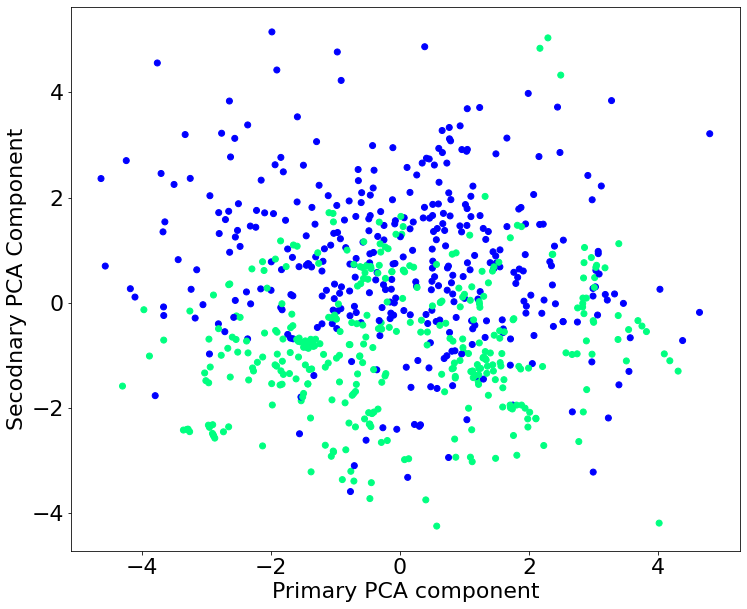

In [60]:
# use bala
#pcab = PCA(n_components=10)
Xbpca = pca.fit_transform(Xbt)
plot_pca(pca,Xbpca,yb_class,2)

# retraining it with the balanced data set will hopefully better the model by seeing features better representative of positive cases

# re-trying the SVM with the balanced pca features

###to-do - test hyperparam of # fo components to use in training

In [61]:
svm = sklearn.svm.LinearSVC()
svm.fit(Xbpca[:,0:3],yb_class)
svm.score(Xbpca[:,0:3],yb_class)
p = np.array(svm.predict(Xbpca[:,0:3]))
cf = classification_report(yb_class,p)
print(cf)
#print('Lower accuracy indicative of the difficulty of positive clasification')

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       364
           1       0.76      0.77      0.77       364

    accuracy                           0.77       728
   macro avg       0.77      0.77      0.77       728
weighted avg       0.77      0.77      0.77       728



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# testing on test/valid set to see if balancing helped any

In [62]:
X21pcab = pca.transform(X21t)
svmb_preds = svm.predict(X21pcab[:,0:3])
print('SVM 2021 predictions: W/class balance ')
cf = classification_report(sweet_g21,svmb_preds)
print(cf)

SVM 2021 predictions: W/class balance 
              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79        52
         1.0       0.42      0.62      0.50        16

    accuracy                           0.71        68
   macro avg       0.64      0.68      0.65        68
weighted avg       0.76      0.71      0.72        68



In [63]:
print('One can see with the over-sampling with 1-to-1 we overpredict success, albeit with better recall')
test_21.iloc[np.where(sweet_g21 == 1)]

One can see with the over-sampling with 1-to-1 we overpredict success, albeit with better recall


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
6,Houston,Amer,26,24,120.6,90.9,0.9626,51.3,42.9,16.3,...,28.0,30.7,42.4,49.9,43.0,35.5,28.5,65.0,4.0,2.0
7,Alabama,SEC,30,24,111.0,88.1,0.9343,51.3,45.3,18.6,...,29.8,28.6,31.9,50.1,46.4,35.1,28.8,73.9,6.8,2.0
11,Arkansas,SEC,28,22,110.4,91.2,0.8997,51.5,47.6,17.4,...,26.2,32.7,29.3,51.9,46.9,33.9,32.6,73.1,4.6,3.0
12,Florida St.,ACC,22,16,117.8,94.0,0.9305,54.4,46.5,20.1,...,31.4,32.7,36.3,52.1,44.2,39.0,33.3,70.4,2.5,4.0
16,Villanova,BE,22,16,117.9,96.7,0.9076,52.8,51.8,13.5,...,24.8,30.0,25.8,52.8,51.0,35.2,35.4,65.1,3.2,5.0
18,Creighton,BE,28,20,114.4,94.3,0.9025,55.7,46.9,15.8,...,28.2,26.9,25.7,56.3,46.1,36.7,32.1,69.1,3.5,5.0
22,USC,P12,29,22,112.0,92.0,0.9052,52.1,45.4,18.1,...,27.3,37.5,24.8,52.1,42.2,34.8,34.2,67.2,3.6,6.0


In [64]:
test_21.iloc[np.where(svmb_preds== 1)]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0
5,Ohio St.,B10,30,21,122.1,97.0,0.9340,53.1,48.9,15.3,...,27.4,37.6,33.8,52.1,47.4,36.5,34.1,66.9,6.0,2.0
6,Houston,Amer,26,24,120.6,90.9,0.9626,51.3,42.9,16.3,...,28.0,30.7,42.4,49.9,43.0,35.5,28.5,65.0,4.0,2.0
7,Alabama,SEC,30,24,111.0,88.1,0.9343,51.3,45.3,18.6,...,29.8,28.6,31.9,50.1,46.4,35.1,28.8,73.9,6.8,2.0
9,Texas,B12,26,19,113.8,93.5,0.9058,52.9,46.7,20.2,...,26.9,34.0,36.7,52.4,45.8,35.7,32.3,69.1,4.2,3.0
11,Arkansas,SEC,28,22,110.4,91.2,0.8997,51.5,47.6,17.4,...,26.2,32.7,29.3,51.9,46.9,33.9,32.6,73.1,4.6,3.0


# Got 7 TP, 16 FP w/ 1:1

In [ ]:
# TO - DO - create function for a given sklearn classification model - LinearSVC, 
# Random Forest, MLP, and maybe SVC and balance rf